In [32]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
import pickle
import os
from sklearn.model_selection import GridSearchCV
import yfinance as yf
import json
import time
sns.set()
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import BatchNormalization
import datetime as dt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout



In [33]:
df = pdr.get_data_yahoo('AMZN', start = dt.datetime(2016,1,1), end = (dt.date.today() - timedelta(days=1)))

In [34]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,657.719971,627.510010,656.289978,636.989990,9314500,636.989990
2016-01-05,646.909973,627.650024,646.859985,633.789978,5822600,633.789978
2016-01-06,639.789978,620.309998,622.000000,632.650024,5329200,632.650024
2016-01-07,630.000000,605.210022,621.799988,607.940002,7074900,607.940002
2016-01-08,624.140015,606.000000,619.659973,607.049988,5512900,607.049988
...,...,...,...,...,...,...
2021-04-23,3375.000000,3308.500000,3319.100098,3340.879883,3192800,3340.879883
2021-04-26,3428.449951,3330.939941,3348.000000,3409.000000,4880700,3409.000000
2021-04-27,3460.000000,3398.010010,3443.469971,3417.429932,3827100,3417.429932


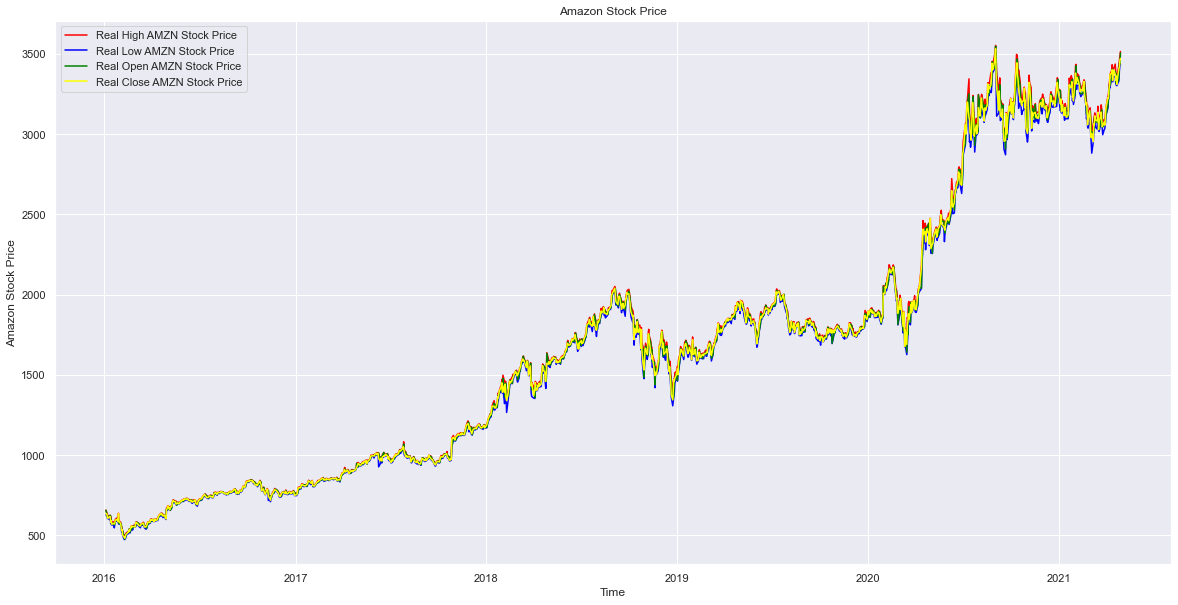

In [35]:
plt.plot(df.reset_index().loc[:, 'Date'], df['High'], color = 'red', label = 'Real High AMZN Stock Price')
plt.plot(df.reset_index().loc[:, 'Date'], df['Low'], color = 'blue', label = 'Real Low AMZN Stock Price')
plt.plot(df.reset_index().loc[:, 'Date'], df['Open'], color = 'green', label = 'Real Open AMZN Stock Price')
plt.plot(df.reset_index().loc[:, 'Date'], df['Close'], color = 'yellow', label = 'Real Close AMZN Stock Price')
#plt.plot(df.reset_index().loc[:, 'Date'], df[['High', 'Low', 'Open', 'Close']], color = 'red', label = 'Real AMZN Stock Price')
#plt.plot(df.loc[:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted AMZ Stock Price')
#plt.xticks(np.arange(0,458,50))
plt.title('Amazon Stock Price')
plt.xlabel('Time')
plt.ylabel('Amazon Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

In [36]:
def set_SMA(df, num_days):
    return df['Close'].rolling(window = num_days, min_periods=0).mean()

In [37]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [38]:
def set_ATR(df, num_days):
    prev_close = df['Close'].shift(1)
    TR = np.maximum((df['High'] - df['Low']), 
                        np.maximum(abs(df['High'] - prev_close), 
                        abs(prev_close - df['Low'])))
    
    return Wilder(TR, num_days)

In [39]:
def set_STOCH(df, num_days):
    Lowest = df['Low'].rolling(window = num_days, min_periods=0).min()
    High = df['High'].rolling(window = num_days, min_periods=0).max()

    Stochastic = ((df['Close'] - Lowest)/(High - Lowest))*100

    Stochastic_D = Stochastic.rolling(window = num_days).mean()
    return Stochastic_D

In [40]:
def set_MACD(df, num_days):
    small_days = df['Close'].ewm(span=(num_days - 6), adjust=False, min_periods=0).mean()
    large_days = df['Close'].ewm(span=(num_days + 6), adjust=False, min_periods=0).mean()
    return large_days - small_days

In [41]:
def set_BBANDS(df, num_days):
    #Bollinger Bands
    Mean = df['Close'].rolling(window=(num_days + 6), min_periods=0).mean()
    SD = df['Close'].rolling(window=(num_days + 6), min_periods=0).std()
    Upperband = Mean + 2*SD
    Lowerband = Mean - 2*SD
    return (Upperband + Lowerband)/2

In [42]:
df['SMA'] = set_SMA(df, 50)
#df['ATR'] = set_ATR(df, 50)
df['Stoch'] = set_STOCH(df, 50)
df['MACD'] = set_MACD(df, 50)
df['BBANDS'] = set_BBANDS(df, 50)

In [43]:
df = df.dropna()

In [44]:
df

,High,Low,Open,Close,Volume,Adj Close,SMA,Stoch,MACD,BBANDS
Date,,,,,,,,,,
2016-03-15,581.520020,567.000000,571.000000,577.020020,3876800,577.020020,566.118199,32.058374,5.450587,566.118199
2016-03-16,581.320007,571.140015,576.640015,574.270020,3537700,574.270020,564.863799,32.590562,5.197955,566.278038
2016-03-17,571.400024,555.010010,569.510010,559.440002,5928100,559.440002,563.376800,33.205509,5.095676,566.146538
2016-03-18,562.330017,546.090027,560.940002,552.080017,7296900,552.080017,561.765400,33.497638,5.062290,565.881132
2016-03-21,555.239990,538.580017,548.909973,553.979980,5155700,553.979980,560.686199,34.368667,5.005836,565.660740
...,...,...,...,...,...,...,...,...,...,...
2021-04-23,3375.000000,3308.500000,3319.100098,3340.879883,3192800,3340.879883,3182.453789,48.689985,-11.192731,3197.015882
2021-04-26,3428.449951,3330.939941,3348.000000,3409.000000,4880700,3409.000000,3185.391191,49.544643,-12.454684,3198.738560
2021-04-27,3460.000000,3398.010010,3443.469971,3417.429932,3827100,3417.429932,3188.185591,50.263037,-13.677694,3200.281952


In [45]:
df = df.drop('Volume', axis=1).drop('Adj Close', axis=1)

In [46]:
train_size = int(df.shape[0] * 0.75)
df_train = df[:train_size]
df_target = df_train[['High', 'Low', 'Open', 'Close']]

In [47]:
df_train

,High,Low,Open,Close,SMA,Stoch,MACD,BBANDS
Date,,,,,,,,
2016-03-15,581.520020,567.000000,571.000000,577.020020,566.118199,32.058374,5.450587,566.118199
2016-03-16,581.320007,571.140015,576.640015,574.270020,564.863799,32.590562,5.197955,566.278038
2016-03-17,571.400024,555.010010,569.510010,559.440002,563.376800,33.205509,5.095676,566.146538
2016-03-18,562.330017,546.090027,560.940002,552.080017,561.765400,33.497638,5.062290,565.881132
2016-03-21,555.239990,538.580017,548.909973,553.979980,560.686199,34.368667,5.005836,565.660740
...,...,...,...,...,...,...,...,...
2020-01-10,1906.939941,1880.000000,1905.369995,1883.160034,1796.053193,63.810164,-6.229927,1793.079636
2020-01-13,1898.000000,1880.800049,1891.310059,1891.300049,1798.279395,64.412222,-6.713614,1795.321958
2020-01-14,1887.109985,1858.550049,1885.880005,1869.439941,1800.134993,64.829701,-6.944578,1797.237492


In [48]:
sc = MinMaxScaler(feature_range = (0, 1))
target_set=df_target.values
train_set=df_train.values
training_set_scaled = sc.fit_transform(train_set)
target_set_scaled = sc.fit_transform(target_set)

In [49]:
X_train = []
y_train = []
for i in range(50,len(train_set)):
    X_train.append(training_set_scaled[i-50:i,:])
    y_train.append(target_set_scaled[i,:])
    
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(918, 50, 8)
(918, 4)


In [50]:
mod=Sequential()
mod.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
mod.add(Dropout(0.2))
mod.add(LSTM(units = 64, return_sequences = True))
mod.add(Dropout(0.1))
   
mod.add((LSTM(units = 64)))
mod.add(Dropout(0.1))
mod.add((Dense(units = 16, activation='tanh')))
mod.add((Dense(units = 4, activation='tanh')))
mod.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy','mean_squared_error'])
mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 64)            18688     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

In [65]:
model_history = mod.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0011 - accuracy: 0.3660 - mean_squared_error: 0.0011
Epoch 2/50
29/29 [==============================] - 1s 42ms/step - loss: 0.0010 - accuracy: 0.3627 - mean_squared_error: 0.0010
Epoch 3/50
29/29 [==============================] - 1s 42ms/step - loss: 0.0011 - accuracy: 0.3573 - mean_squared_error: 0.0011
Epoch 4/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0011 - accuracy: 0.3453 - mean_squared_error: 0.0011
Epoch 5/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0013 - accuracy: 0.3824 - mean_squared_error: 0.0013
Epoch 6/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0012 - accuracy: 0.3693 - mean_squared_error: 0.0012
Epoch 7/50
29/29 [==============================] - 1s 41ms/step - loss: 0.0012 - accuracy: 0.3508 - mean_squared_error: 0.0012
Epoch 8/50
29/29 [==============================] - 1s 43ms/step - loss: 0.0012 - accuracy: 0.3551 - mea

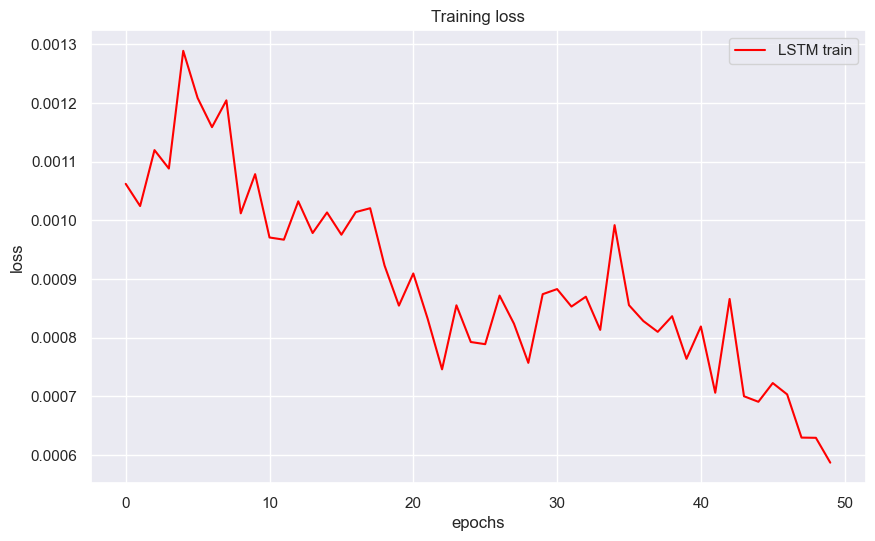

In [66]:
plt.figure(figsize=(10, 6), dpi=100)
plt.plot(model_history.history['loss'], label='LSTM train', color='red')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.title('Training loss')
plt.show()

In [67]:
df_test=df[train_size - 50:]
test_set=df_test.values
test_set_scaled = sc.fit_transform(test_set)

In [68]:
df_pred = df_test.copy()
df_pred = df_pred[50:]

In [69]:
test_set.shape

(373, 8)

In [70]:
X_test = []

for i in range(50, len(test_set)):
    X_test.append(test_set_scaled[i-50:i,:])

X_test= np.array(X_test)
X_test

array([[[0.03534126, 0.09027441, 0.08798263, ..., 0.        ,
         0.94271265, 0.01210935],
        [0.03104958, 0.08736144, 0.08370025, ..., 0.01967614,
         0.93849774, 0.01186154],
        [0.03293239, 0.08462049, 0.0851487 , ..., 0.03759062,
         0.93532183, 0.01170104],
        ...,
        [0.07790363, 0.12496643, 0.12824523, ..., 0.57613809,
         0.79297212, 0.02560791],
        [0.07333507, 0.12310683, 0.12109221, ..., 0.57888919,
         0.79144903, 0.02659721],
        [0.0770619 , 0.12898112, 0.12672855, ..., 0.58174575,
         0.78846165, 0.02801723]],

       [[0.03104958, 0.08736144, 0.08370025, ..., 0.01967614,
         0.93849774, 0.01186154],
        [0.03293239, 0.08462049, 0.0851487 , ..., 0.03759062,
         0.93532183, 0.01170104],
        [0.02406107, 0.07954705, 0.07682014, ..., 0.05253891,
         0.93254502, 0.01124243],
        ...,
        [0.07333507, 0.12310683, 0.12109221, ..., 0.57888919,
         0.79144903, 0.02659721],
        [0.0

In [71]:
predicted_stock_price = mod.predict(X_test)

In [72]:
predicted_stock_price = predicted_stock_price.T
    
for i in range(4):
    predicted_stock_price[i] = predicted_stock_price[i] * (1 / sc.scale_[i]) + sc.data_min_[i]
    
predicted_stock_price = predicted_stock_price.T

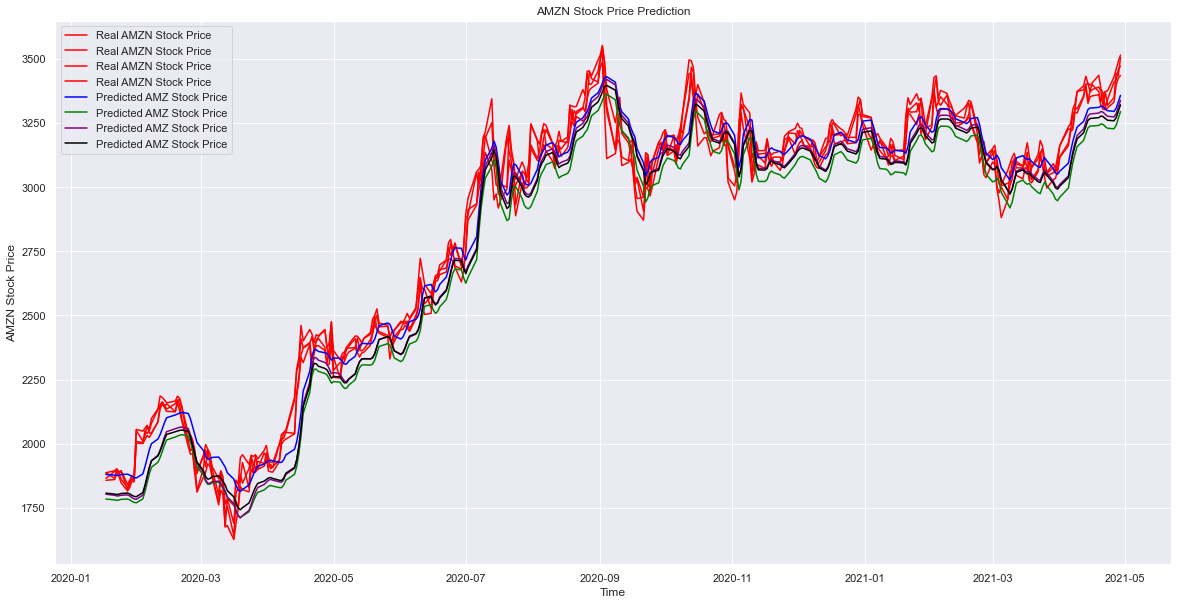

In [73]:
plt.plot(df.reset_index().loc[train_size:, 'Date'],df_pred[['High', 'Low', 'Open', 'Close']], color = 'red', label = 'Real AMZN Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'],predicted_stock_price.T[0], color = 'blue', label = 'Predicted AMZ Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'],predicted_stock_price.T[1], color = 'green', label = 'Predicted AMZ Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'],predicted_stock_price.T[2], color = 'purple', label = 'Predicted AMZ Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'],predicted_stock_price.T[3], color = 'black', label = 'Predicted AMZ Stock Price')

#plt.xticks(np.arange(0,458,50))
plt.title('AMZN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error
Y_real = []
for val in df_pred[['Close']].values:
    Y_real.append(val[0])
    
Y_test = list(predicted_stock_price.T[3].copy())

sum = 0
for i in range(len(Y_test)):
    diff = (Y_real[i] - Y_test[i])
    sum += (diff ** 2)

print(sum/len(X_test))
print(mean_squared_error(Y_test, Y_real))


12259.718441055378
12259.718441055378


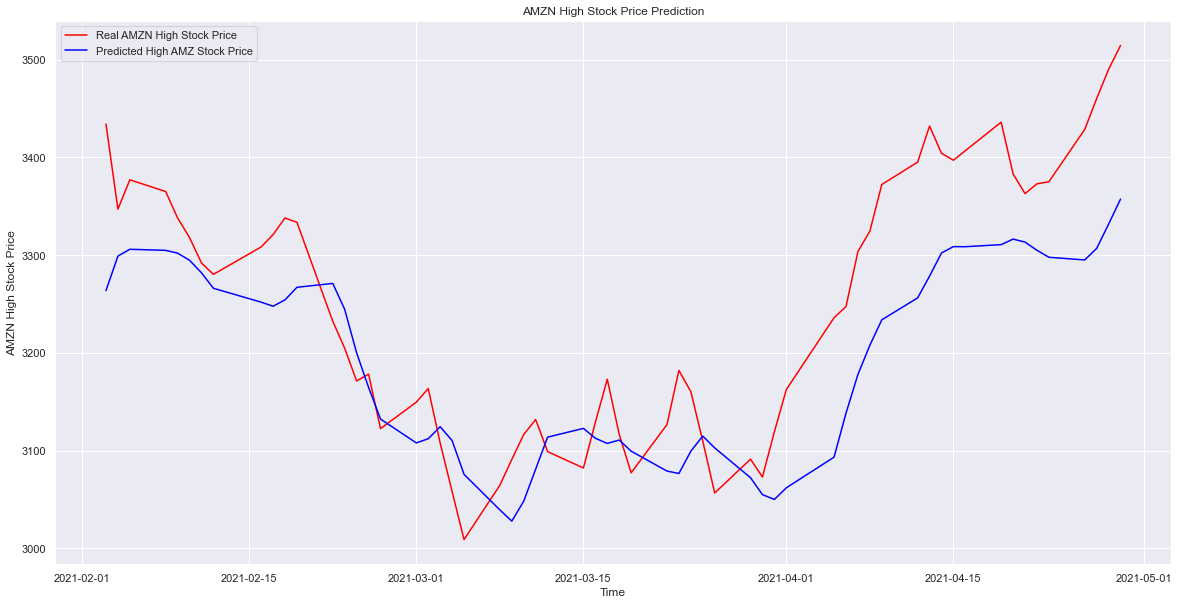

In [81]:
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),df_pred['High'].tail(60), color = 'red', label = 'Real AMZN High Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),predicted_stock_price.T[0][-60:], color = 'blue', label = 'Predicted High AMZ Stock Price')

#plt.xticks(np.arange(0,458,50))
plt.title('AMZN High Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN High Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

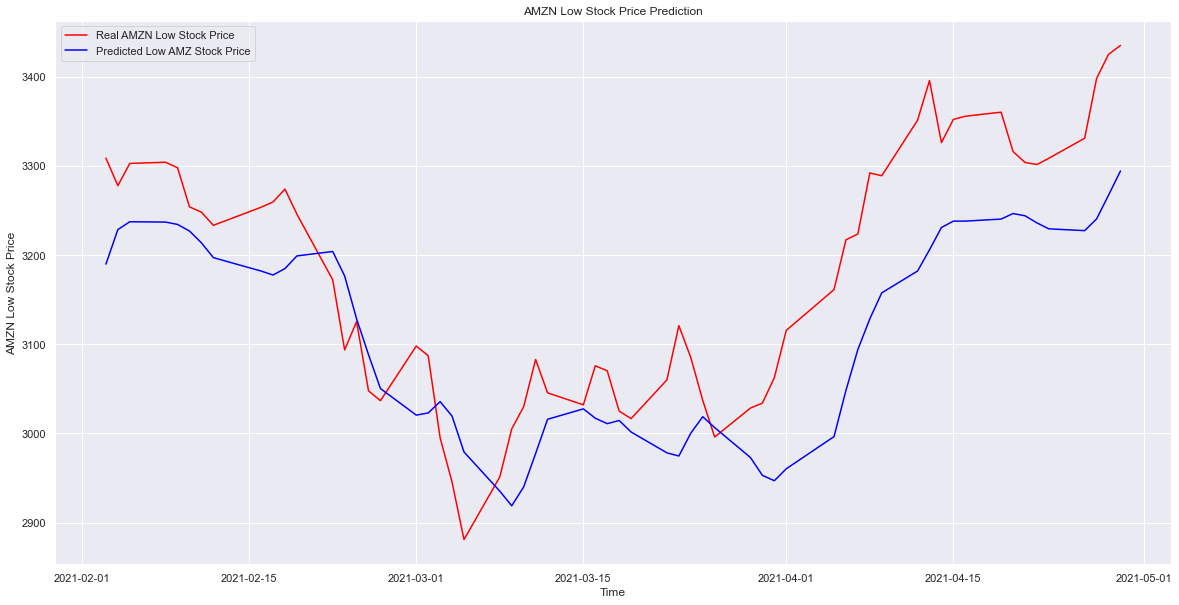

In [82]:
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),df_pred['Low'].tail(60), color = 'red', label = 'Real AMZN Low Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),predicted_stock_price.T[1][-60:], color = 'blue', label = 'Predicted Low AMZ Stock Price')

#plt.xticks(np.arange(0,458,50))
plt.title('AMZN Low Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Low Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

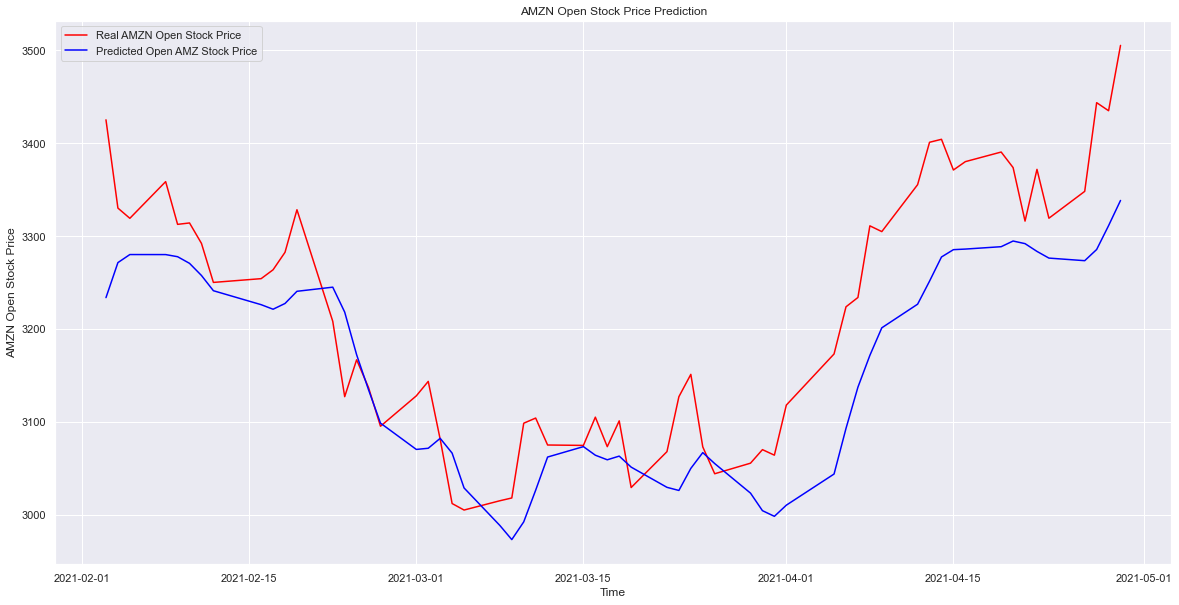

In [83]:
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),df_pred['Open'].tail(60), color = 'red', label = 'Real AMZN Open Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),predicted_stock_price.T[2][-60:], color = 'blue', label = 'Predicted Open AMZ Stock Price')

#plt.xticks(np.arange(0,458,50))
plt.title('AMZN Open Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Open Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

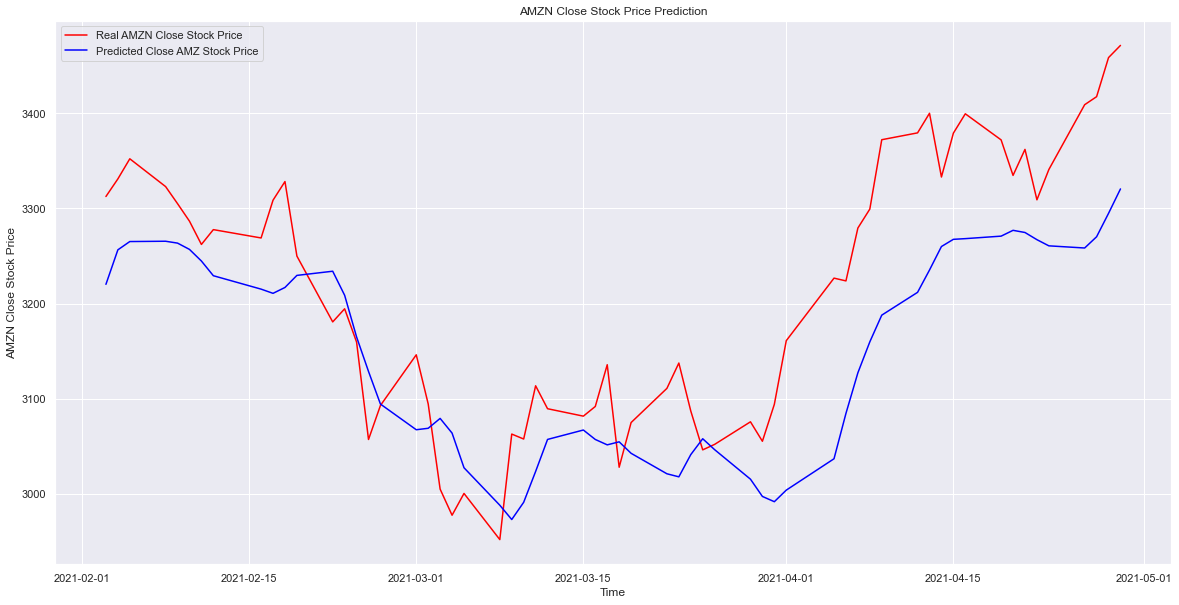

In [84]:
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),df_pred['Close'].tail(60), color = 'red', label = 'Real AMZN Close Stock Price')
plt.plot(df.reset_index().loc[train_size:, 'Date'].tail(60),predicted_stock_price.T[3][-60:], color = 'blue', label = 'Predicted Close AMZ Stock Price')

#plt.xticks(np.arange(0,458,50))
plt.title('AMZN Close Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMZN Close Stock Price')
plt.legend()
plt.gcf().set_size_inches(20,10)
plt.show()

In [85]:
def predict_next_day(df, preds, day):
    
    # predict new values    
    new_preds = mod.predict(preds)

    # scale
    for i in range(4):
        new_preds[0][i] = new_preds[0][i] * (1 / sc.scale_[i]) + sc.data_min_[i]   
    
    # add to df
    new_row = df.iloc[-1]
    new_row.name = day
    df = df.append(new_row)
    df.iloc[-1, 4:] = 0
    for i in range(4):
        df.iloc[-1, i] = new_preds[0][i]
        
    # calculate technical indicators
    df['SMA'] = set_SMA(df, 50)
    df['Stoch'] = set_STOCH(df, 50)
    df['MACD'] = set_MACD(df, 50)
    df['BBANDS'] = set_BBANDS(df, 50)
    
    # add ti to new_preds
    new_preds = np.append(new_preds[0], df.iloc[-1, 4:])

    # update and return preds
    preds = preds[0][1:]
    new_preds = np.array(new_preds)
    new_preds = np.reshape(new_preds, (1, 8))
    preds = np.append(preds, new_preds, axis=0)
    preds = np.reshape(preds, (1, preds.shape[0], preds.shape[1]))
    
    return preds, df

In [86]:
def predict_x_days(df, preds, x):
    today = dt.date.today()
    
    for i in range(x):
        day = today + timedelta(days = i)
        preds, df = predict_next_day(df, preds, day)
        
    return df

In [92]:
df_extrapolated = df.copy()
preds = X_test[-1:]
df_extrapolated = predict_x_days(df_extrapolated, preds, 10)

In [93]:
df_extrapolated

,High,Low,Open,Close,SMA,Stoch,MACD,BBANDS
Date,,,,,,,,
2016-03-15 00:00:00,581.520020,567.000000,571.000000,577.020020,577.020020,NaN,0.000000,NaN
2016-03-16 00:00:00,581.320007,571.140015,576.640015,574.270020,575.645020,NaN,0.025731,575.645020
2016-03-17 00:00:00,571.400024,555.010010,569.510010,559.440002,570.243347,NaN,0.188176,570.243347
2016-03-18 00:00:00,562.330017,546.090027,560.940002,552.080017,565.702515,NaN,0.406527,565.702515
2016-03-21 00:00:00,555.239990,538.580017,548.909973,553.979980,563.358008,NaN,0.589440,563.358008
...,...,...,...,...,...,...,...,...
2021-05-05,3531.204834,3460.544434,3523.488037,3481.502197,3226.122168,58.067123,-22.205448,3222.788718
2021-05-06,3531.156250,3460.782227,3523.333496,3481.541504,3233.894399,59.631300,-23.014186,3225.526424
2021-05-07,3531.066162,3460.936768,3523.142578,3481.575439,3240.603110,60.927724,-23.724292,3229.663487


In [94]:
df_extrapolated.tail(11)

,High,Low,Open,Close,SMA,Stoch,MACD,BBANDS
Date,,,,,,,,
2021-04-29 00:00:00,3514.449951,3435.000000,3505.100098,3471.310059,3195.229995,51.631876,-16.638874,3204.830527
2021-04-30,3357.270752,3294.240723,3338.225098,3320.494141,3195.075278,51.605188,-16.557698,3205.107208
2021-05-01,3517.488525,3447.245605,3508.524902,3470.431885,3199.485918,52.476762,-17.859957,3208.390276
2021-05-02,3528.669189,3457.261475,3520.934326,3479.709229,3205.465303,53.727977,-19.119629,3212.275622
2021-05-03,3530.632568,3459.335449,3523.062012,3481.113770,3211.197578,54.901734,-20.264406,3215.907833
2021-05-04,3531.121094,3460.139160,3523.501465,3481.417236,3217.635322,56.268680,-21.291161,3219.701891
2021-05-05,3531.204834,3460.544434,3523.488037,3481.502197,3226.122168,58.067123,-22.205448,3222.788718
2021-05-06,3531.156250,3460.782227,3523.333496,3481.541504,3233.894399,59.631300,-23.014186,3225.526424
2021-05-07,3531.066162,3460.936768,3523.142578,3481.575439,3240.603110,60.927724,-23.724292,3229.663487
